<center> 
    <font face="Baskerville Old Face">
        <font size="6"> <h1> Uno strumento di analisi statistica delle prove d'esame di programmazione</h1> </font>
        <font size="3"> <h2> Progetto di tesi triennale in informatica - Università statale di Milano</h2> </font>          
        <font size="3"> <h3> Marco Cordoni </h3> </font>     
    </font>
</center>

In [2]:
# importo le funzioni definite nel file IrtFunctions.r
source("IrtFunctions.r")

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2> Esempio di apllicazione del modello ad 1 parametro</h2> </font>  
    </font>
</center>

<center> <font size="10" face="Baskerville Old Face"> One-parameter logistic (1PL) </font> </center> 
<br>
<font size="5">
    \begin{equation} 
    p(x_j = 1 | \theta_i, \beta_j) = \frac{\mathrm{e}^{(\theta_i - \beta_j)}}
                                      {1 + \mathrm{e}^{(\theta_i - \beta_j)}}
    \end{equation}
</font>
<br>

In [3]:
# Simulo la presenza di un esercizio di diffioltà medio-alta e di uno studenti di abilità media
# Il modello dovrà ritornare una probabilià abbastanza bassa 
pl1(ability = 0, difficulty = 2)

[1] 0.1192029

In [4]:
# Viceversa dovrei ottenere una probabilità alta
pl1(ability = 2, difficulty = 0)

[1] 0.8807971

In [5]:
# Nel caso abilità e difficoltà siano equivalenti si ottiene sempre una probabilità del 50%
pl1(ability = 0, difficulty = 0)
pl1(ability = 1, difficulty = 1)

[1] 0.5

[1] 0.5

In [91]:
# Sfruttando il modello precedentemente posso applicarlo ad un ampio numero di studente ed esercizi
# Definisco il numero di colonne e righe
nItem <- 5
nStud <- 10

# Genero i valori randomicamente
vectDiff <- rnorm(nItem)
vectAbil <- rnorm(nStud)

# Creo un dataframe delle giuste dimensioni e assegno a righe e colonne i nomi opportuni
df <- data.frame(matrix(ncol = length(vectDiff), nrow = length(vectAbil)))
rownames(df) <- unlist(lapply(c(1:nStud), function(p) paste("Studente", p)))
colnames(df) <- unlist(lapply(c(1:nItem), function(p) paste("Esercizio", p)))

# Applico il modello
cp <- calcProbabilites(items = df, diff = vectDiff, abil = vectAbil)

In [92]:
# Rendo i dati più leggibili per gli utenti
showProbabilities(df = cp)

,Esercizio.1,Esercizio.2,Esercizio.3,Esercizio.4,Esercizio.5
Studente 1,43 %,60 %,41 %,55 %,60 %
Studente 2,14 %,25 %,13 %,22 %,25 %
Studente 3,42 %,60 %,40 %,55 %,60 %
Studente 4,35 %,52 %,33 %,47 %,52 %
Studente 5,69 %,82 %,67 %,78 %,82 %
Studente 6,71 %,83 %,69 %,80 %,83 %
Studente 7,40 %,58 %,38 %,53 %,58 %
Studente 8,38 %,56 %,36 %,51 %,56 %
Studente 9,38 %,55 %,36 %,50 %,55 %
Studente 10,74 %,85 %,73 %,83 %,85 %


<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2> Simulazione dei dati</h2> </font>          
    </font>
</center>

In [8]:
# Definisco il numero di colonne e righe
nItem <- 5
nStud <- 10

# Genero i valori randomicamente
vectDiff <- rnorm(nItem)
vectAbil <- rnorm(nStud)

# Simulo un esame
generateDichot(diff = vectDiff, abil = vectAbil)

X1,X2,X3,X4,X5
1,1,0,1,0
0,0,1,0,0
1,1,1,1,1
1,1,1,1,1
1,1,1,1,1
1,0,0,1,0
1,1,1,1,1
0,1,0,0,0
1,1,1,0,0
1,1,1,1,1


In [9]:
# Se assumessi una abilità costante e un livello di difficoltà crescente otterrei una tabella con 
# un maggior numero di 1 nelle prime colonne perchè è più facile superare gli esercizi

vectDiff <- seq(from = -3, to = 3, by = 0.6) 
vectAbil <- rep(0, times = 15)

generateDichot(diff = vectDiff, abil = vectAbil)

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11
1,1,1,1,1,0,0,0,0,0,1
1,1,1,1,1,1,1,0,1,0,0
0,1,1,1,0,0,0,1,0,0,0
1,1,0,0,1,0,0,0,0,0,0
1,1,1,1,1,1,0,0,1,0,0
1,0,0,0,1,0,1,1,0,0,0
1,1,1,0,1,0,0,0,0,1,0
1,1,1,1,1,0,1,0,0,0,0
1,1,1,1,1,0,1,0,0,0,0
1,1,1,1,1,1,0,0,0,0,0


<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2> Esempio di uso di stimatori e confronto grafico per le difficoltà</h2> </font>          
    </font>
</center>

In [3]:
# Modifico la dimensione dei grafici
width <- 7
height <- 5
sizePlot(width, height)

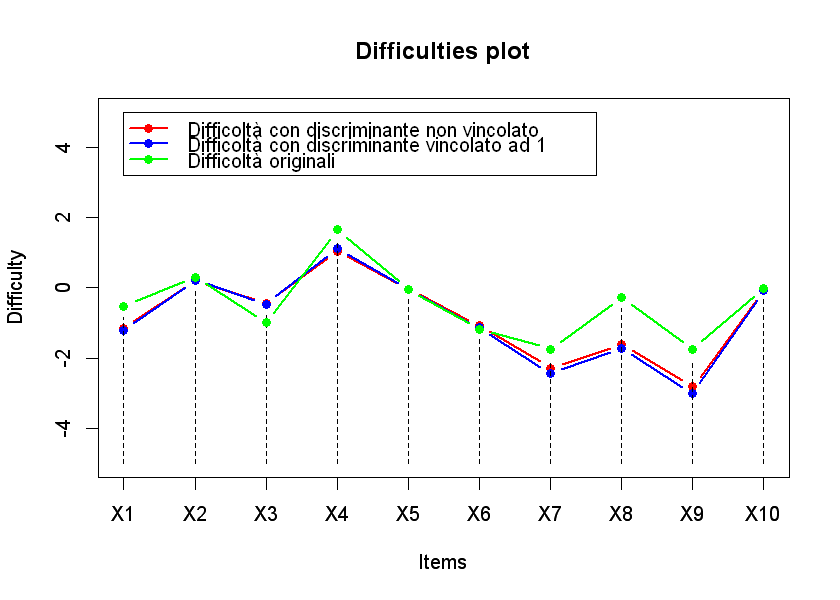

In [4]:
# Definisco il numero di items e il numero di studenti 
numItems <- 10
numStudents <- 35

# Definisco quante estrazioni effettuare rispetto al numero di studenti
bootStrapVal <- 10

# Genero randomicamente difficoltà e abilità
diff <- rnorm(numItems)
abil <- rnorm(numStudents)

# Genero i dati
datiDichot <- generateDichot(diff, abil)

# Bootstrapping
numExtractions <- bootStrapVal * numStudents
bottDatiDichot <- bootstrapping(datiDichot, numExtractions)

# Stimo le difficoltà con entrambi i metodi
difficDichotF <- estimateDifficultiesDichotFreeDiscrim(bottDatiDichot)
difficDichotO <- estimateDifficultiesDichotOneDiscrim(bottDatiDichot)

# Visualizzo e confronto i grafici relativi alle difficoltà stimate con entrambi i metodi e le difficoltà iniziali
plotDifficultiesDichot(datiDichot, difficDichotF)
par(new = TRUE)
plotDifficultiesDichot(datiDichot, difficDichotO, color = "blue")
par(new = TRUE)
plotDifficultiesDichot(datiDichot, diff, color = "green")
legend(1, 10, legend=c("Difficoltà con discriminante non vincolato", "Difficoltà con discriminante vincolato ad 1", "Difficoltà originali"), col=c("red", "blue", "green"), lty=1, cex=1, lwd=2, pch=16)

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2>Stima delle abilità e visualizzazione tramite istogramma</h2> </font>          
    </font>
</center>

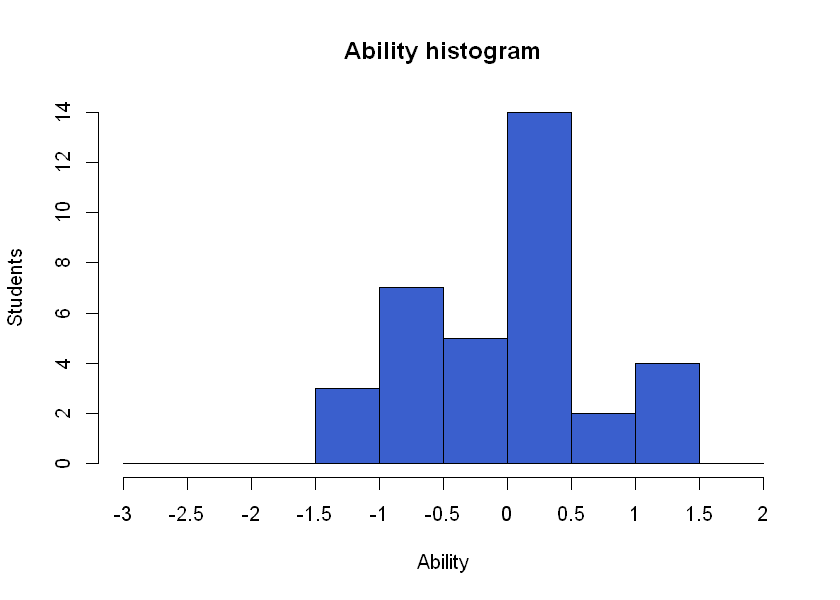

In [5]:
# Stimo le abilità e visualizzo il relativo grafico
abil <- estimateAbilitiesDichot(datiDichot)
plotAbilitiesDichot(abil, start = -3, end = 2, by = 0.5)

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2>Tecniche di validazione</h2> </font>          
    </font>
</center>

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h3>Validazione per differenza</h3> </font>
    </font>
</center>

In [87]:
validationWithDifference(vect1 = diff, vect2 = difficDichotO, label1 = "Difficoltà originali", label2 = "Difficoltà stimate")

Difficoltà originali,Difficoltà stimate,Scostamento
1.267897305,1.0685922,0.20
0.457093314,-0.1988227,0.66
-0.884828120,-1.1035202,0.22
0.003832331,-0.2275306,0.23
0.569932522,-0.0418142,0.61
0.509092729,0.4725934,0.04
0.555349234,0.3283189,0.23
1.206293440,1.0360098,0.17
-1.123092404,-1.2966803,0.17
0.701728770,0.9399469,0.24


<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h3>Validazione per correlazione</h3> </font>
    </font>
</center>

In [88]:
validationWithCor(vect1 = diff, vect2 = difficDichotO)

[1] 0.9521322

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h3>Validazione per confronto grafico</h3> </font>
    </font>
</center>

NULL

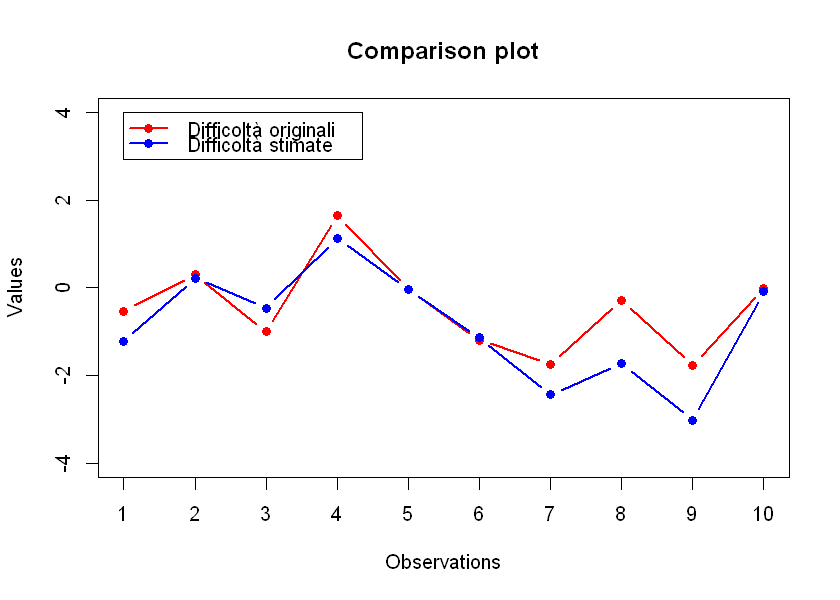

In [6]:
validationWithPlot(vect1 = diff, vect2 = difficDichotO, label1 = "Difficoltà originali", label2 = "Difficoltà stimate")

<center> 
    <font face="Baskerville Old Face">
        <font size="3"> <h2> Gestione dei dati assenti (NA)</h2> </font>          
    </font>
</center>

In [25]:
# Definisco il numero di items e il numero di studenti 
numItems <- 10
numStudents <- 35

# Definisco quante estrazioni effettuare rispetto al numero di studenti
bootStrapVal <- 10

# Genero randomicamente difficoltà e abilità
diff <- rnorm(numItems)
abil <- rnorm(numStudents)

# Genero i dati
datiDichot <- generateDichot(diff, abil)

# Definisco la probabilità di rimpiazzare gli 0 con NA
prob <- 0.3

# Applico il rimpiazzamento dei valori 0 in NA, la tebella ottenuto simula dei valori reali in cui sono 
# presenti esercizi passati, falliti e dati assenti
datiDichotNA <- replaceRandomZeroWithNA(datiDichot, prob)

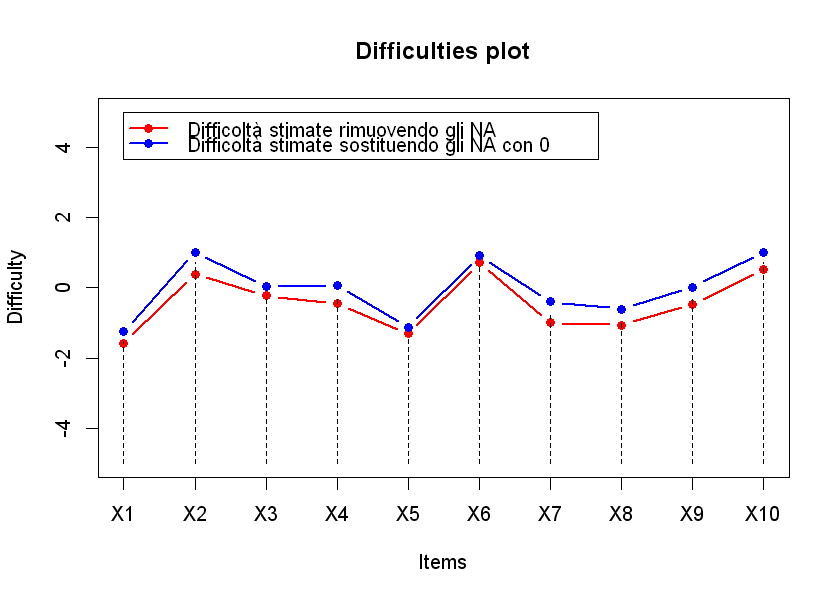

In [27]:
# Applico il bootstrapping
datiDichotNABoot <- bootstrapping(datiDichotNA, numStudents * bootStrapVal)

# Eseguo la stima rimuovendo gli NA prima della computazione
estDiffNULL <- estimateDifficultiesDichotOneDiscrim(datiDichotNABoot, forNA = NULL)

# Eseguo la stima sostituendo gli NA con 0 
estDiffZero <- estimateDifficultiesDichotOneDiscrim(replaceNaWithZero(datiDichotNABoot))

# Confronto i grafici relativi alle difficoltà stimate nei 2 modi
plotDifficultiesDichot(datiDichot, estDiffNULL)
par(new = TRUE)
plotDifficultiesDichot(datiDichot, estDiffZero, color = "blue")
legend(1, 10, legend=c("Difficoltà stimate rimuovendo gli NA", "Difficoltà stimate sostituendo gli NA con 0"), col=c("red", "blue"), lty=1, cex=1, lwd=2, pch=16)

In [9]:
#' Produce una matrice dicotomica definendo la condizione per cui un esercizio viene definito come passato(1) oppure no(0)
#' @param session Sessione considerata
#' @param vote Stringa che indica come valutare gli esercizi
#' @param maxError Se scelto il criterio "errors", questo campo indica il massimo numero di errori commettibili
#' @param percTestCaseOk Se scelto il criterio "testCase", questo campo indica la percentuale di test case che devono 
#' essere corretti rispetto al totale
#' @param keepNA Paramatreo booleano per indicare se indicare con NA i voti in cui gli studenti non hanno raggiunto la votazione
#' precedente al paramentro di valutazione indicato (es. evaluateSource(session, vote = "compiles", keepNA = TRUE), i voti
#' NA riguarderanno gli studenti che non hanno raggiunto lo step precedente, cioè l'upload)
#' @return Data frame dicotomico, possiede una riga per studente e una colonna per esercizio, nelle intersezioni vi sono i 
#' risultati delle valutazioni sulla base delle specifiche inserite
#' @examples
#' sourceData <- "data.R"      
#' source(sourceData)
#' numSessions <- 5
#' session <- sessions[numSessions]
#' vote <- "testCase"
#' p <- 0.5
#' evaluateSource(session, vote, percTestCaseOk = p)             
evaluateSource <- function(session, vote, maxError, percTestCaseOk, keepNA = FALSE) {      
    results <- get(paste("results_", session, sep = ""))
    
    if(vote == "uploaded")
        results[,,vote]
    else if(vote == "compiles"){
        dfC <- results[,,vote]
        dfU <- results[,,"uploaded"]
        
        if(keepNA)
            dfC[dfU == 0] <- NA   
        dfC
    }
    else if(vote == "errors"){
        df <- results[,,vote]
        df[df <= maxError] <- 1 
        df[df > maxError] <- 0
        
        if(!keepNA)
            df[is.na(df)] <- 0            
        df
    }
    else if(vote == "testCase"){
        cases <- get(paste("cases_", session, sep = ""))
        df <- results[,,"oks"]
        df <- t((t(df)) / c(cases)) 
        df[df >= percTestCaseOk] <- 1
        df[df < percTestCaseOk] <- 0
        
        if(!keepNA)
            df[is.na(df)] <- 0     
        df
    }        
}

In [2]:
sourceData <- "data.R"
source(sourceData)
bootstrapVal <- 10

<font face="Baskerville Old Face">
    <font size="5"> 
    
Di seguito andrò ad analizzare i risultati delle sessioni. <br><br>

Per tale analisi ho scelto di considerate un esercizio superato solo se passa almeno il 50% dei test case ad esso associati, ho fatto questa assunzione perchè in esame non sono ritenuti generalmente corretti gli esercizi solo perchè è stato effettuato il loro upload, compilano o semplicemente perchè non presentano errori di esecuzione.<br><br>

In ogni tabella dicotomica provvederò ad eliminare le colonne totalmente uniformi o quasi al fine di permettere la convergenza dell'algoritmo di stima.
    </font>
</font>
<br><br><br><br>

<font face="Baskerville Old Face">
    <font size="5"> 
Nel seguente grafico possiamo notare un andamento crescente delle difficoltà, potremmo presuppore che il professore assegni gli esercizi in esame mostrando prima quelli più semplici e veloci da superare e lasciando per ultimi quelli che richiedo più tempo e impegno.
    </font>
</font>

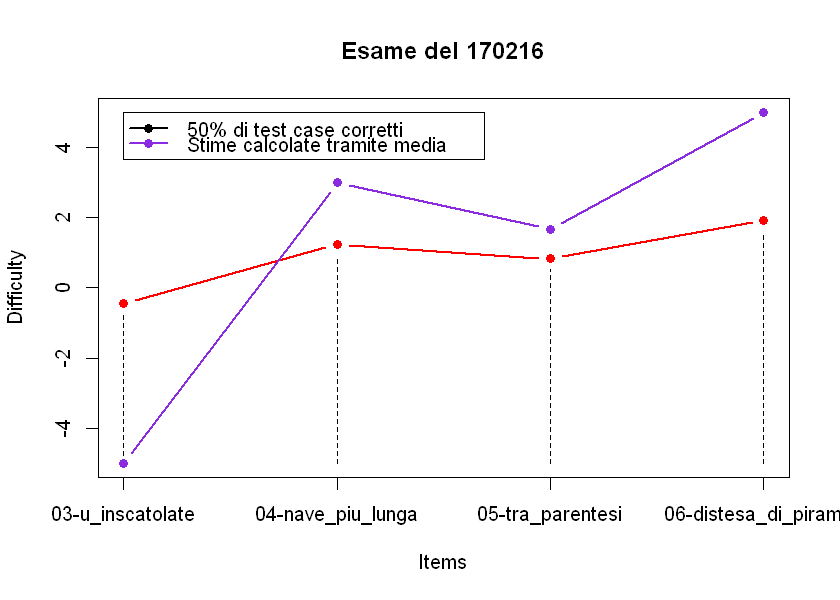

In [68]:
numSessions <- 2
session <- sessions[numSessions]
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)
nStud <- nrow(evalWithTestCase)

evalWithTestCase <- evalWithTestCase[,c(3:6)]

diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))
plotDifficultiesDichot(evalWithTestCase, diffTestCase, name = paste("Esame del",session))
legend(1, 10, legend=c("50% di test case corretti", "Stime calcolate tramite media"), col=c("black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Visualizzo e confronto i grafici relativi alle difficoltà stimate tenendo conto: se è stato effettuato l'upload, se compila, se sono stati commessi meno di 2 errori di esecuzione e se almeno il 50% dei test case sono corretti
    </font>
</font>

<font face="Baskerville Old Face">
    <font size="4"> 
L'elevato numero di studenti (46) permette di avere una buona fiducia nei dati ottenuti<br><br>

Dal grafico si possono trarre diverse conclusioni: 
<ul>
   <li>Le stime legate all'upload, compilazione ed errori in esecuzione coincidono quasi sempre, da ciò deduciamo che gli 
       studenti che consegnano gli esercizi lo fanno solo nel caso compilino e abbiano pochi errori di esecuzione o nessuno</li>
   <li>Le difficoltà hanno un andamento crescente, quindi il professore potrebbe aver assegnato gli esercizi considerando
       che gli studenti avrebbero dovuto impegnarsi maggiormente negli ultimi</li>
   <li>Nella fase iniziale la stima per test case si discosta abbastanza dalle altre, sovrapponendosi ad essi successivamente,
       questo potrebbe essere indicativo del fatto che gli studenti all'inizio erano meno abili, forse a causa di spiegazioni 
       poco chiare da parte del professore</li>
</ul>
    </font>
</font>

In [115]:
numSessions <- 6 
session <- sessions[numSessions]

evalWithUpload   <- evaluateSource(session, vote = "uploaded")
evalWithCompiles <- evaluateSource(session, vote = "compiles")
evalWithErrors   <- evaluateSource(session, vote = "errors", maxError = 2)
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)

nStud <- nrow(evalWithTestCase)

diffUpload   <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithUpload,   n = bootstrapVal * nStud))
diffCompiles <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithCompiles, n = bootstrapVal * nStud))
diffErrors   <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithErrors,   n = bootstrapVal * nStud))
diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))

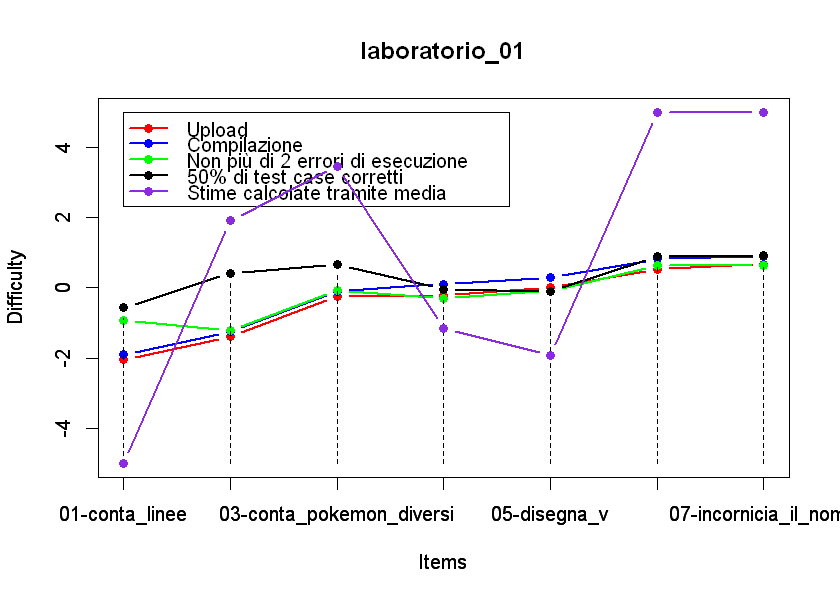

In [116]:
plotDifficultiesDichot(evalWithUpload, diffUpload, color = "red", name = session)
par(new = TRUE)
plotDifficultiesDichot(evalWithCompiles, diffCompiles, color = "blue", name = "")
par(new = TRUE)
plotDifficultiesDichot(evalWithErrors, diffErrors, color = "green", name = "")
par(new = TRUE)
plotDifficultiesDichot(evalWithTestCase, diffTestCase, color = "black", name = "")
legend(1, 10, legend=c("Upload", "Compilazione", "Non più di 2 errori di esecuzione", "50% di test case corretti", "Stime calcolate tramite media"), col=c("red", "blue", "green", "black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Confronto graficamente le stime ottuenuto dal 10%, 30%, 50% e 100% dei test case corretti e noto una differenza minima o quasi nulla
    </font>
</font>

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

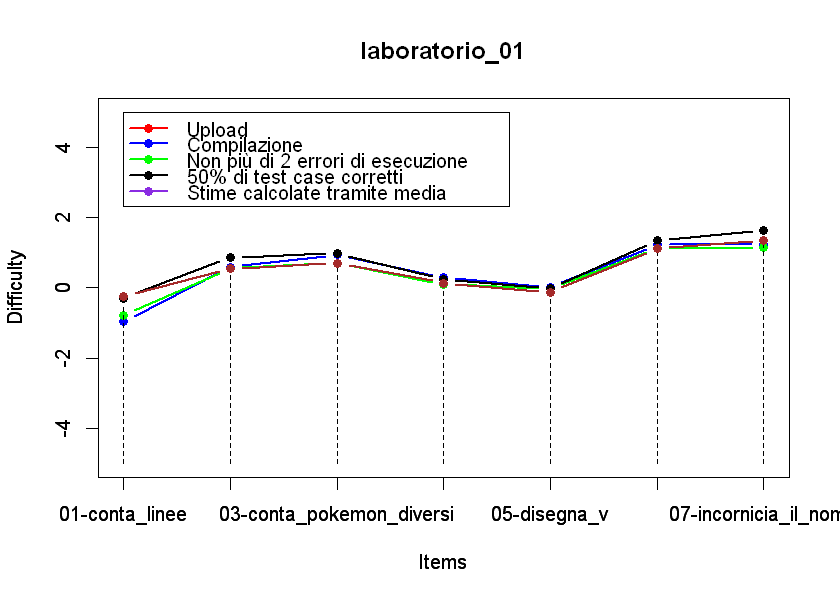

In [181]:
evalWithTestCase10 <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.1)
evalWithTestCase30 <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.3)
evalWithTestCase50 <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)
evalWithTestCase80 <- evaluateSource(session, vote = "testCase", percTestCaseOk = 1)

diffTestCase10 <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase10, n = bootstrapVal * nStud))
diffTestCase30 <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase30, n = bootstrapVal * nStud))
diffTestCase50 <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase50, n = bootstrapVal * nStud))
diffTestCase80 <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase80, n = bootstrapVal * nStud))

plotDifficultiesDichot(evalWithTestCase20, diffTestCase20, color = "blue", name = session)
par(new = TRUE)
plotDifficultiesDichot(evalWithTestCase40, diffTestCase40, color = "green", name = "")
par(new = TRUE)
plotDifficultiesDichot(evalWithTestCase60, diffTestCase60, color = "black", name = "")
par(new = TRUE)
plotDifficultiesDichot(evalWithTestCase80, diffTestCase80, color = "brown", name = "")
legend(1, 10, legend=c("Upload", "Compilazione", "Non più di 2 errori di esecuzione", "50% di test case corretti", "Stime calcolate tramite media"), col=c("red", "blue", "green", "black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Anche nel laboratorio 2 si può notare una sovrapposizione tra le stime considerando la presenza di meno di 2 errori di 
esecuzione e il raggiungimento di almeno il 50% di test case corretti ma a differenza del precedente grafico questo non ha un andamento particolarmente crescente, anzi, è quasi sempre fisso su una difficoltà medio-alta, da ciò possiamo dedurre che gli studenti hanno avuto particolari difficoltà in tutto gli esercizi, scontrandoci con l'ipotesi formulata al punto precedente sul crescente livello di difficoltà pensato dal professore all'interno dei laboratori
    </font>
</font>

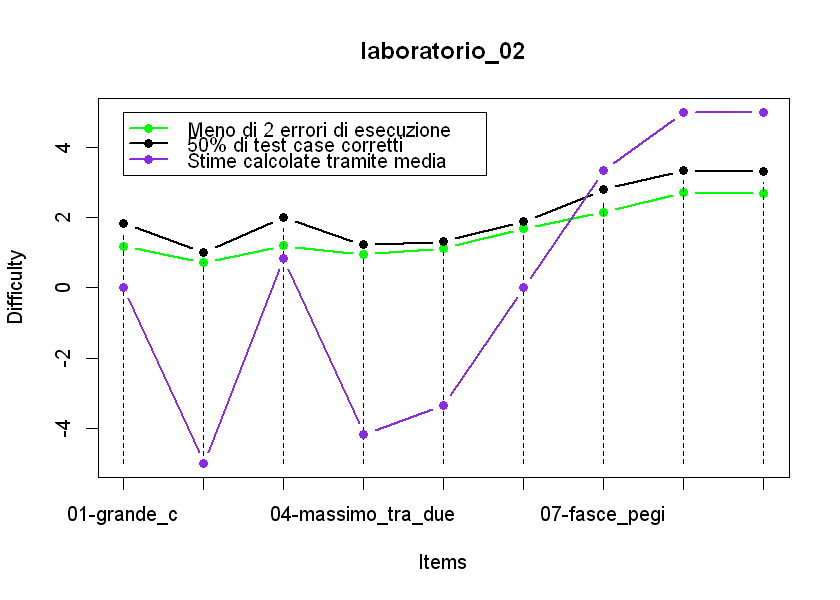

In [112]:
numSessions <- 7
session <- sessions[numSessions]

evalWithErrors   <- evaluateSource(session, vote = "errors", maxError = 2)
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)

nStud <- nrow(evalWithTestCase)

diffErrors   <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithErrors,   n = bootstrapVal * nStud))
diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))

plotDifficultiesDichot(evalWithErrors, diffErrors, color = "green", name = session)
par(new = TRUE)
plotDifficultiesDichot(evalWithTestCase, diffTestCase, color = "black", name = "")
legend(1, 10, legend=c("Meno di 2 errori di esecuzione", "50% di test case corretti", "Stime calcolate tramite media"), col=c("green", "black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Nel laboratorio 3 notiamo che la difficoltà stimata si assesta per tutti gli esercizi su un livello medio-basso 
con una leggere crescita verso gli ultimi
    </font>
</font>

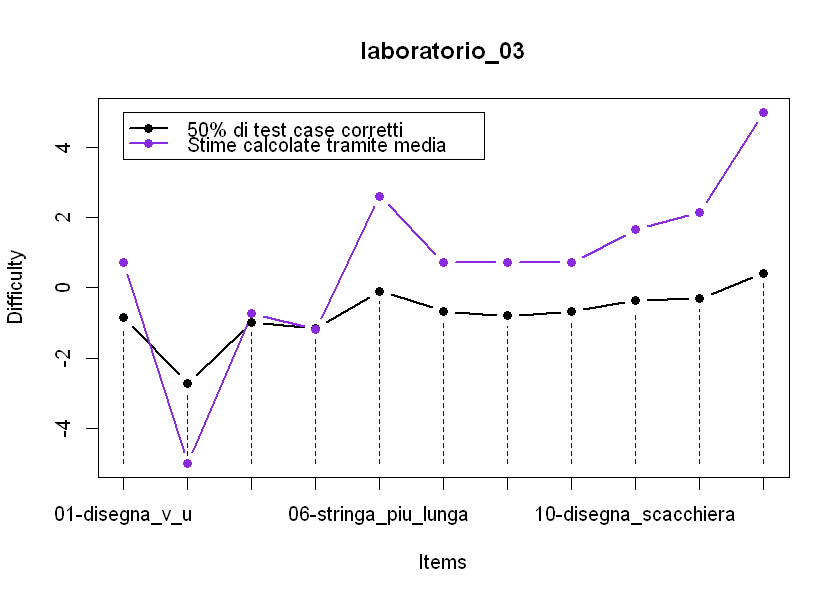

In [86]:
numSessions <- 8
session <- sessions[numSessions]
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)
nStud <- nrow(evalWithTestCase)

evalWithTestCase <- evalWithTestCase[,-c(5)]

diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))

plotDifficultiesDichot(evalWithTestCase, diffTestCase, color = "black", name = session)
legend(1, 10, legend=c("50% di test case corretti", "Stime calcolate tramite media"), col=c("black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Nel laboratorio 5 notiamo che la difficoltà stimata ha un andamento costante per quasi tutti gli esercizi   
    </font>
</font>

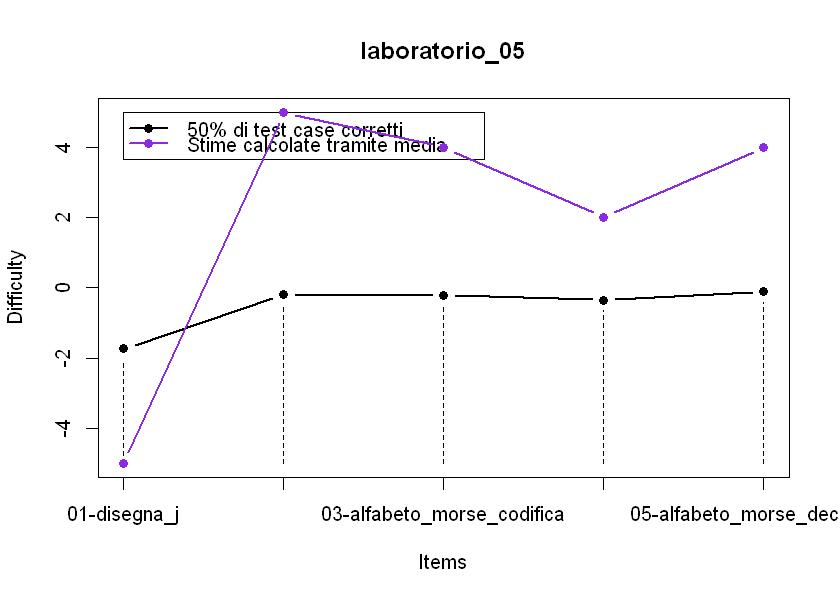

In [83]:
numSessions <- 10
session <- sessions[numSessions]
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)
nStud <- nrow(evalWithTestCase)

# Rimuovo la colonna 6 perchè a causa della scarsità di studentiche hanno passato i test l'algoritmo non convergerebbe
evalWithTestCase <- evalWithTestCase[,-c(6)]

diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))

plotDifficultiesDichot(evalWithTestCase, diffTestCase, color = "black", name = session)
legend(1, 10, legend=c("50% di test case corretti", "Stime calcolate tramite media"), col=c("black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")

<br><br><br><br>
<font face="Baskerville Old Face">
    <font size="5"> 
Infine nel laboratorio 6 notiamo che la difficoltà stimata ha un andamento crescente con qualche diminuzione ma non abbastanza significativa da negare l'esistenza di un aumento di difficoltà in relazione al numero dell'esercizio
    </font>
</font>

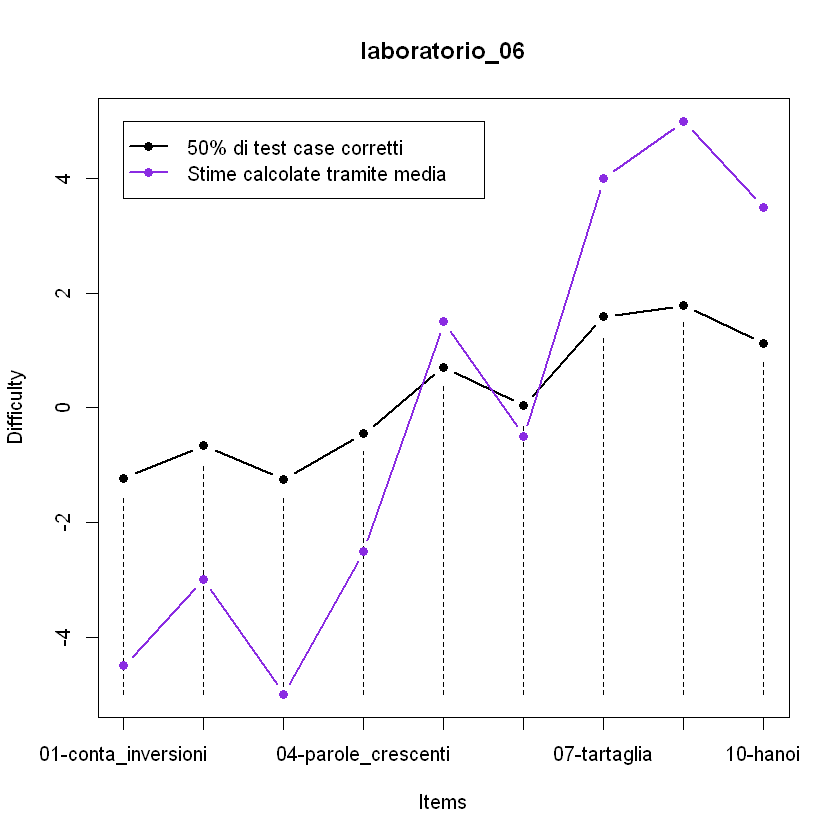

In [3]:
numSessions <- 11
session <- sessions[numSessions]
evalWithTestCase <- evaluateSource(session, vote = "testCase", percTestCaseOk = 0.5)
nStud <- nrow(evalWithTestCase)

evalWithTestCase <- evalWithTestCase[,-c(9,11)]

diffTestCase <- estimateDifficultiesDichotOneDiscrim(bootstrapping(evalWithTestCase, n = bootstrapVal * nStud))

plotDifficultiesDichot(evalWithTestCase, diffTestCase, color = "black", name = session)
legend(1, 10, legend=c("50% di test case corretti", "Stime calcolate tramite media"), col=c("black", "blueviolet"), lty=1, cex=1, lwd=2, pch=16)
par(new = TRUE)
cs <- colSums(evalWithTestCase)
nItems <- ncol(evalWithTestCase)
plot(1 - cs/nStud, type = "b", col =  "blueviolet", pch = 16, lwd = 2, xaxt = "n", yaxt = "n", xlab = "", ylab = "")